In [1]:
%matplotlib inline

In [3]:

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

.. Note ::
   Download the data from
   `here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`_
   and extract it to the current directory.



In [5]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

from google.colab import drive
drive.mount('/content/drive')

data_dir = '/content/drive/MyDrive/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Visualize a few images
Let's visualize a few training images so as to understand the data
augmentations.



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


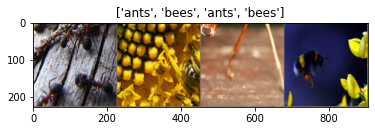

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [24]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    t_loss,t_acc = np.zeros(num_epochs),np.zeros(num_epochs)
    v_loss,v_acc = np.zeros(num_epochs),np.zeros(num_epochs)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()


                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                v_loss[epoch] = epoch_loss
                v_acc[epoch] = epoch_acc

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    plt.plot(v_loss)
    plt.plot(v_acc)
    plt.xlabel('No.Epochs')
    plt.ylabel('Validation')
    plt.show()

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [25]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [26]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.4550 Acc: 0.7787
val Loss: 0.1918 Acc: 0.9281

Epoch 1/24
----------
train Loss: 0.6785 Acc: 0.7418
val Loss: 0.6945 Acc: 0.7712

Epoch 2/24
----------
train Loss: 0.6714 Acc: 0.8074
val Loss: 0.7419 Acc: 0.7582

Epoch 3/24
----------
train Loss: 0.6093 Acc: 0.7869
val Loss: 0.3599 Acc: 0.8824

Epoch 4/24
----------
train Loss: 0.5073 Acc: 0.8279
val Loss: 0.3227 Acc: 0.9085

Epoch 5/24
----------
train Loss: 0.4545 Acc: 0.8279
val Loss: 0.2524 Acc: 0.8889

Epoch 6/24
----------
train Loss: 0.7900 Acc: 0.7541
val Loss: 0.8946 Acc: 0.8235

Epoch 7/24
----------
train Loss: 0.4584 Acc: 0.8607
val Loss: 0.2734 Acc: 0.9020

Epoch 8/24
----------
train Loss: 0.4155 Acc: 0.8238
val Loss: 0.1836 Acc: 0.9281

Epoch 9/24
----------
train Loss: 0.4229 Acc: 0.8443
val Loss: 0.1683 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.4374 Acc: 0.8279
val Loss: 0.1651 Acc: 0.9216

Epoch 11/24
----------
train Loss: 0.4616 Acc: 0.8279
val Loss: 0.2299 Acc: 0.9150

Epoch 12/24
----------
t

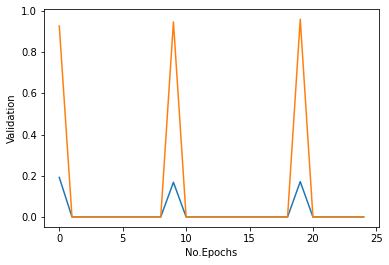

In [27]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


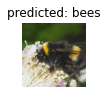

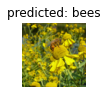

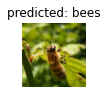

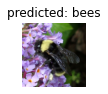

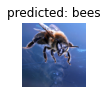

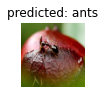

In [28]:
visualize_model(model_ft)

Another set with changed parameters

Epoch 0/14
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 1.0542 Acc: 0.6230
val Loss: 2.2211 Acc: 0.6405

Epoch 1/14
----------
train Loss: 1.1800 Acc: 0.5943
val Loss: 1.0301 Acc: 0.6405

Epoch 2/14
----------
train Loss: 1.0571 Acc: 0.6311
val Loss: 2.4319 Acc: 0.5882

Epoch 3/14
----------
train Loss: 1.2036 Acc: 0.6311
val Loss: 0.7156 Acc: 0.7778

Epoch 4/14
----------
train Loss: 0.7679 Acc: 0.7213
val Loss: 0.6389 Acc: 0.6601

Epoch 5/14
----------
train Loss: 0.9034 Acc: 0.6967
val Loss: 1.4038 Acc: 0.7320

Epoch 6/14
----------
train Loss: 0.8895 Acc: 0.6352
val Loss: 0.6076 Acc: 0.7582

Epoch 7/14
----------
train Loss: 0.5487 Acc: 0.6967
val Loss: 0.4535 Acc: 0.8039

Epoch 8/14
----------
train Loss: 0.4338 Acc: 0.7746
val Loss: 0.4220 Acc: 0.8366

Epoch 9/14
----------
train Loss: 0.4044 Acc: 0.7992
val Loss: 0.3969 Acc: 0.8105

Epoch 10/14
----------
train Loss: 0.4455 Acc: 0.7664
val Loss: 0.3565 Acc: 0.8693

Epoch 11/14
----------
train Loss: 0.3865 Acc: 0.8607
val Loss: 0.3687 Acc: 0.8431

Epoch 12/14
----------
t

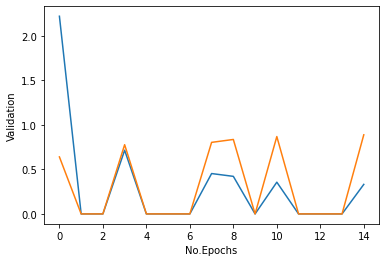

In [29]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.005, momentum=0.8)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=15)

Another set of changed parameters to study the validation accuracy vs epoch

Epoch 0/19
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.8615 Acc: 0.5246
val Loss: 0.6806 Acc: 0.5490

Epoch 1/19
----------
train Loss: 0.6697 Acc: 0.5656
val Loss: 0.6056 Acc: 0.6536

Epoch 2/19
----------
train Loss: 0.6071 Acc: 0.7172
val Loss: 0.5589 Acc: 0.7124

Epoch 3/19
----------
train Loss: 0.5927 Acc: 0.6967
val Loss: 0.5252 Acc: 0.7255

Epoch 4/19
----------
train Loss: 0.5891 Acc: 0.7008
val Loss: 0.4846 Acc: 0.8039

Epoch 5/19
----------
train Loss: 0.5364 Acc: 0.7828
val Loss: 0.4604 Acc: 0.8497

Epoch 6/19
----------
train Loss: 0.5325 Acc: 0.7541
val Loss: 0.4231 Acc: 0.8562

Epoch 7/19
----------
train Loss: 0.5272 Acc: 0.7746
val Loss: 0.4274 Acc: 0.8497

Epoch 8/19
----------
train Loss: 0.5122 Acc: 0.7828
val Loss: 0.4323 Acc: 0.8627

Epoch 9/19
----------
train Loss: 0.5064 Acc: 0.7500
val Loss: 0.4199 Acc: 0.8758

Epoch 10/19
----------
train Loss: 0.5282 Acc: 0.7131
val Loss: 0.4360 Acc: 0.8431

Epoch 11/19
----------
train Loss: 0.5216 Acc: 0.7541
val Loss: 0.4170 Acc: 0.8693

Epoch 12/19
----------
t

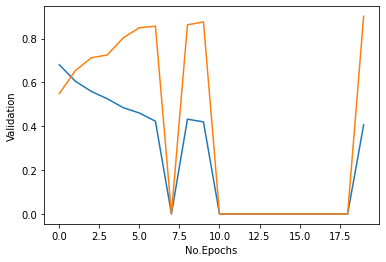

In [30]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0001, momentum=0.5)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)

Another set of changed parameters to study the validation accuracy vs epoch

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.7336 Acc: 0.5287
val Loss: 0.5671 Acc: 0.7451

Epoch 1/24
----------
train Loss: 0.5949 Acc: 0.6680
val Loss: 0.4590 Acc: 0.8301

Epoch 2/24
----------
train Loss: 0.5142 Acc: 0.7541
val Loss: 0.3127 Acc: 0.9085

Epoch 3/24
----------
train Loss: 0.4554 Acc: 0.8197
val Loss: 0.2599 Acc: 0.9216

Epoch 4/24
----------
train Loss: 0.4104 Acc: 0.7992
val Loss: 0.2538 Acc: 0.9281

Epoch 5/24
----------
train Loss: 0.3963 Acc: 0.8443
val Loss: 0.2077 Acc: 0.9542

Epoch 6/24
----------
train Loss: 0.3736 Acc: 0.8361
val Loss: 0.2023 Acc: 0.9477

Epoch 7/24
----------
train Loss: 0.3460 Acc: 0.8361
val Loss: 0.2074 Acc: 0.9281

Epoch 8/24
----------
train Loss: 0.3830 Acc: 0.8361
val Loss: 0.1960 Acc: 0.9542

Epoch 9/24
----------
train Loss: 0.4196 Acc: 0.7951
val Loss: 0.2051 Acc: 0.9216

Epoch 10/24
----------
train Loss: 0.3777 Acc: 0.8484
val Loss: 0.2235 Acc: 0.9216

Epoch 11/24
----------
train Loss: 0.3488 Acc: 0.8361
val Loss: 0.2069 Acc: 0.9346

Epoch 12/24
----------
t

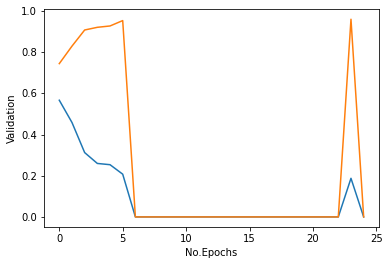

In [31]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.00001, momentum=0.99)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)